In [2]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('dark_background')
from matplotlib import cm

viridis = cm.get_cmap('viridis', 8)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import chart_utils
import analysis_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# # Download CoinMetrics data if needed

# try:
#     os.remove("btc.csv")
# except FileNotFoundError:
#     pass
# !wget https://coinmetrics.io/newdata/btc.csv

--2020-11-30 07:32:29--  https://coinmetrics.io/newdata/btc.csv
Resolving coinmetrics.io (coinmetrics.io)... 104.26.14.66, 172.67.75.174, 104.26.15.66, ...
Connecting to coinmetrics.io (coinmetrics.io)|104.26.14.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2736292 (2.6M) [application/octet-stream]
Saving to: ‘btc.csv’

btc.csv             100%[===================>]   2.61M  --.-KB/s    in 0.1s    

2020-11-30 07:32:29 (25.4 MB/s) - ‘btc.csv’ saved [2736292/2736292]



In [4]:
data = pd.read_csv(
    "btc.csv"
)[['date', 'PriceUSD', 'CapMrktCurUSD', 'CapRealUSD', 'SplyFF']]
# Add in some useful date columns for aggregation
data['CapMrktCurUSDFF'] = data['SplyFF'] * data['PriceUSD']

data['CapRealUSDPctChange'] = (data['CapRealUSD'] / data['CapRealUSD'].shift(1)) - 1
data['CapRealUSDlnPctChange'] = np.log(data['CapRealUSD'] / data['CapRealUSD'].shift(1))

data['CapMrktCurUSDFFPctChange'] = (data['CapMrktCurUSDFF'] / data['CapMrktCurUSDFF'].shift(1)) - 1
data['CapMrktCurUSDFFlnPctChange'] = np.log(data['CapMrktCurUSDFF'] / data['CapMrktCurUSDFF'].shift(1))

for cap_metric in ['CapMrktCurUSD', 'CapRealUSD', 'CapMrktCurUSDFF']:
    data['{}PctChange'.format(cap_metric)] = (data[cap_metric] / data[cap_metric].shift(1)) - 1
    data['{}Change'.format(cap_metric)] = (data[cap_metric] - data[cap_metric].shift(1))
    data['{}lnPctChange'.format(cap_metric)] = np.log(data[cap_metric] / data[cap_metric].shift(1))
    for window_size in [7, 28, 56, 56 * 2]:
        data['{}Roll{}'.format(cap_metric, window_size)] = data[cap_metric].rolling(window_size).mean()
        data['{}Roll{}lnPctChange'.format(cap_metric, window_size)] = np.log(
            data['{}Roll{}'.format(cap_metric, window_size)] / data['{}Roll{}'.format(cap_metric, window_size)].shift(1)) 

data = analysis_utils.get_extra_datetime_cols(data, 'date')
data['days_since_bottom'] = [x.days for x in (pd.to_datetime(data['datetime']) - pd.to_datetime(data['market_cycle']))]
data['days_since_halving'] = [x.days for x in (pd.to_datetime(data['datetime']) - pd.to_datetime(data['halving_era']))]

In [5]:
weekly = data.groupby('week', as_index=False)[['CapMrktCurUSD', 'CapRealUSD', 'CapMrktCurUSDFF', 'PriceUSD']].mean().dropna()
for cap_metric in ['CapMrktCurUSD', 'CapRealUSD', 'CapMrktCurUSDFF']:
    weekly['{}PctChange'.format(cap_metric)] = (weekly[cap_metric] / weekly[cap_metric].shift(1)) - 1
    weekly['{}Change'.format(cap_metric)] = (weekly[cap_metric] - weekly[cap_metric].shift(1))
    weekly['{}lnPctChange'.format(cap_metric)] = np.log(weekly[cap_metric] / weekly[cap_metric].shift(1))

weekly['date'] = [str(x)[:10] for x in weekly['week']]
weekly = analysis_utils.get_extra_datetime_cols(weekly, 'date')
weekly['days_since_bottom'] = [x.days for x in (pd.to_datetime(weekly['datetime']) - pd.to_datetime(weekly['market_cycle']))]
weekly['days_since_halving'] = [x.days for x in (pd.to_datetime(weekly['datetime']) - pd.to_datetime(weekly['halving_era']))]

In [6]:
monthly = data.groupby('month', as_index=False)[['CapMrktCurUSD', 'CapRealUSD', 'CapMrktCurUSDFF', 'PriceUSD']].mean().dropna()
for cap_metric in ['CapMrktCurUSD', 'CapRealUSD', 'CapMrktCurUSDFF']:
    monthly['{}PctChange'.format(cap_metric)] = (monthly[cap_metric] / monthly[cap_metric].shift(1)) - 1
    monthly['{}Change'.format(cap_metric)] = (monthly[cap_metric] - monthly[cap_metric].shift(1))
    monthly['{}lnPctChange'.format(cap_metric)] = np.log(monthly[cap_metric] / monthly[cap_metric].shift(1))

monthly['date'] = [str(x)[:10] for x in monthly['month']]
monthly = analysis_utils.get_extra_datetime_cols(monthly, 'date')
monthly['days_since_bottom'] = [x.days for x in (pd.to_datetime(monthly['datetime']) - pd.to_datetime(monthly['market_cycle']))]
monthly['days_since_halving'] = [x.days for x in (pd.to_datetime(monthly['datetime']) - pd.to_datetime(monthly['halving_era']))]

In [7]:
data.columns.values

array(['date', 'PriceUSD', 'CapMrktCurUSD', 'CapRealUSD', 'SplyFF',
       'CapMrktCurUSDFF', 'CapRealUSDPctChange', 'CapRealUSDlnPctChange',
       'CapMrktCurUSDFFPctChange', 'CapMrktCurUSDFFlnPctChange',
       'CapMrktCurUSDPctChange', 'CapMrktCurUSDChange',
       'CapMrktCurUSDlnPctChange', 'CapMrktCurUSDRoll7',
       'CapMrktCurUSDRoll7lnPctChange', 'CapMrktCurUSDRoll28',
       'CapMrktCurUSDRoll28lnPctChange', 'CapMrktCurUSDRoll56',
       'CapMrktCurUSDRoll56lnPctChange', 'CapMrktCurUSDRoll112',
       'CapMrktCurUSDRoll112lnPctChange', 'CapRealUSDChange',
       'CapRealUSDRoll7', 'CapRealUSDRoll7lnPctChange',
       'CapRealUSDRoll28', 'CapRealUSDRoll28lnPctChange',
       'CapRealUSDRoll56', 'CapRealUSDRoll56lnPctChange',
       'CapRealUSDRoll112', 'CapRealUSDRoll112lnPctChange',
       'CapMrktCurUSDFFChange', 'CapMrktCurUSDFFRoll7',
       'CapMrktCurUSDFFRoll7lnPctChange', 'CapMrktCurUSDFFRoll28',
       'CapMrktCurUSDFFRoll28lnPctChange', 'CapMrktCurUSDFFRoll56',
   

In [8]:
halving_era_map = {
    datetime.date(2009, 1, 3): 1,
    datetime.date(2012, 11, 29): 2,
    datetime.date(2016, 7, 10): 3,
    datetime.date(2020, 5, 11): 4
}

In [9]:
for halving_era in data.halving_era.unique():
    print(halving_era_map.get(halving_era))

1
2
3
4


In [10]:
data.halving_era.unique()

array([datetime.date(2009, 1, 3), datetime.date(2012, 11, 29),
       datetime.date(2016, 7, 10), datetime.date(2020, 5, 11)],
      dtype=object)

In [11]:
data.CapMrktCurUSDRoll28lnPctChange.min() * 100

-3.516910487215067

In [12]:
data.loc[
    data['halving_era'] >= pd.to_datetime('2012-11-29')
].CapMrktCurUSDRoll28lnPctChange.min() * 100

-3.516910487215067

<ipython-input-13-8ef9fe872000>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])


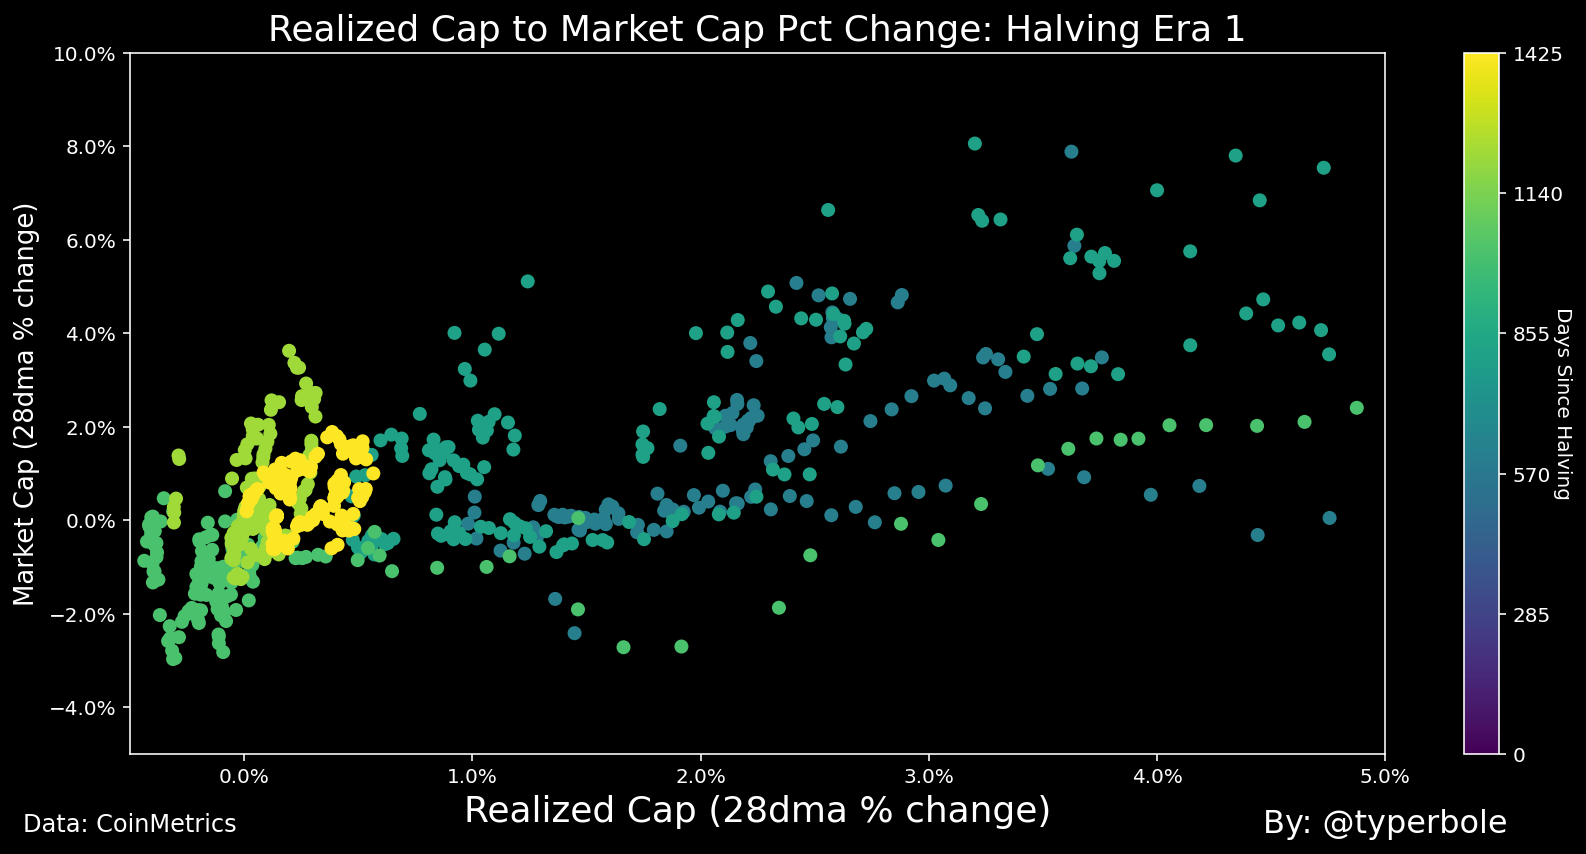

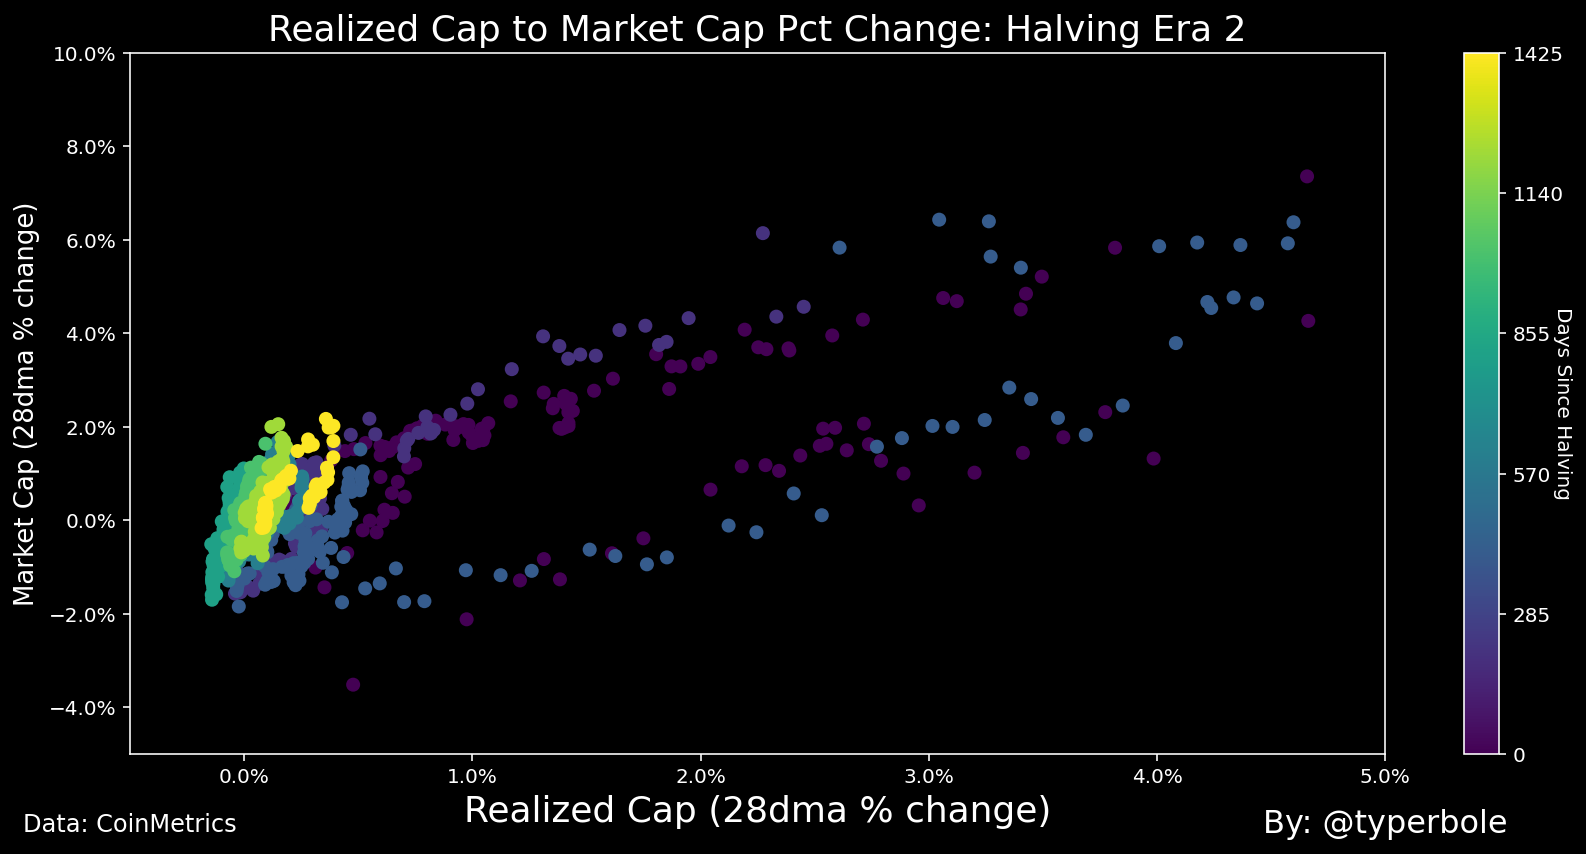

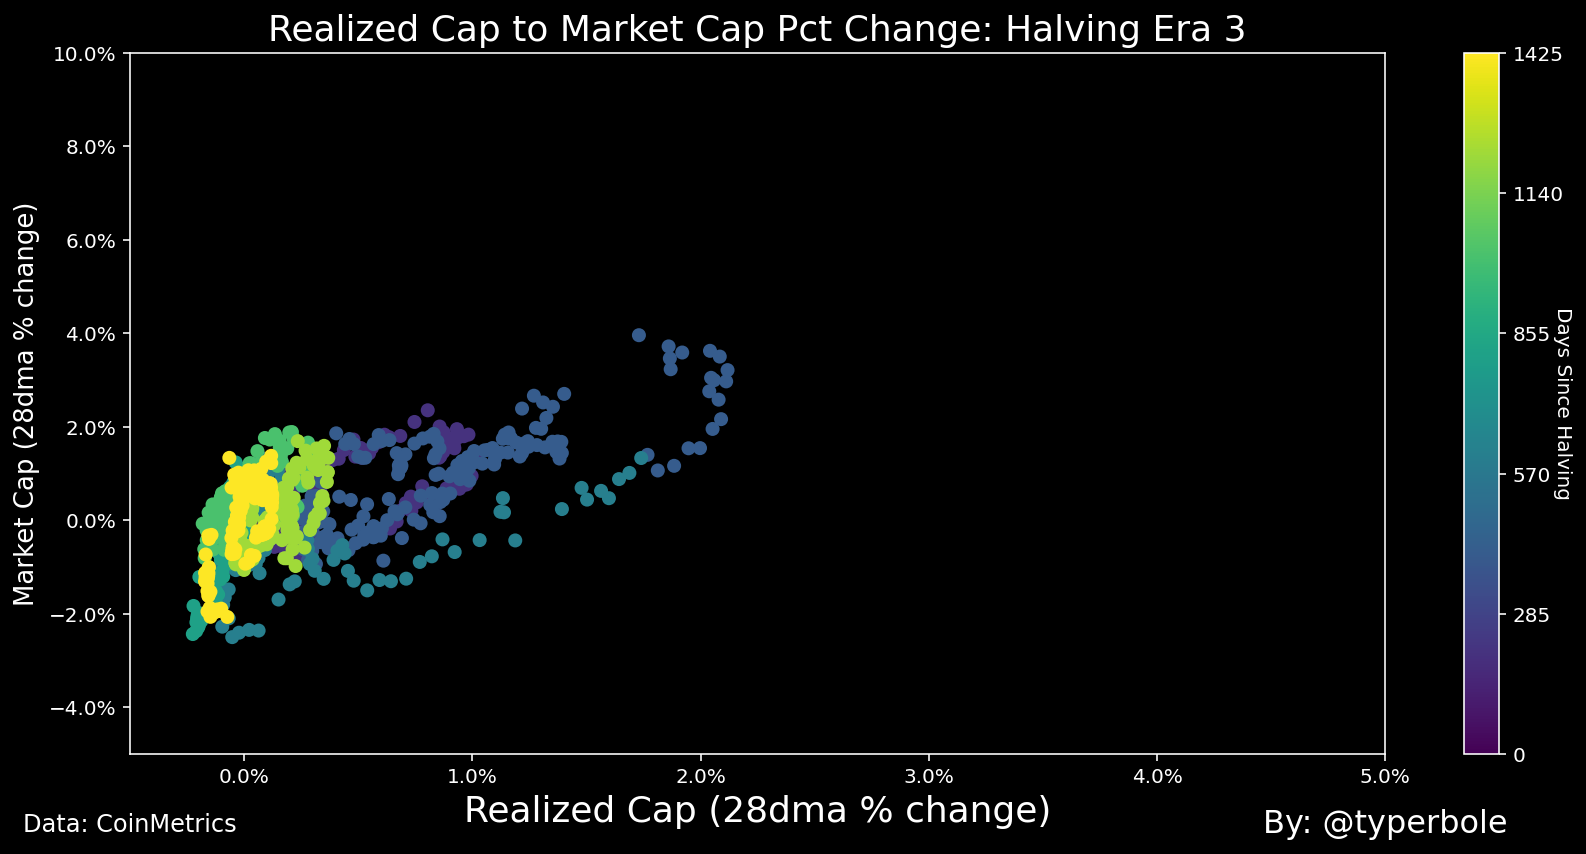

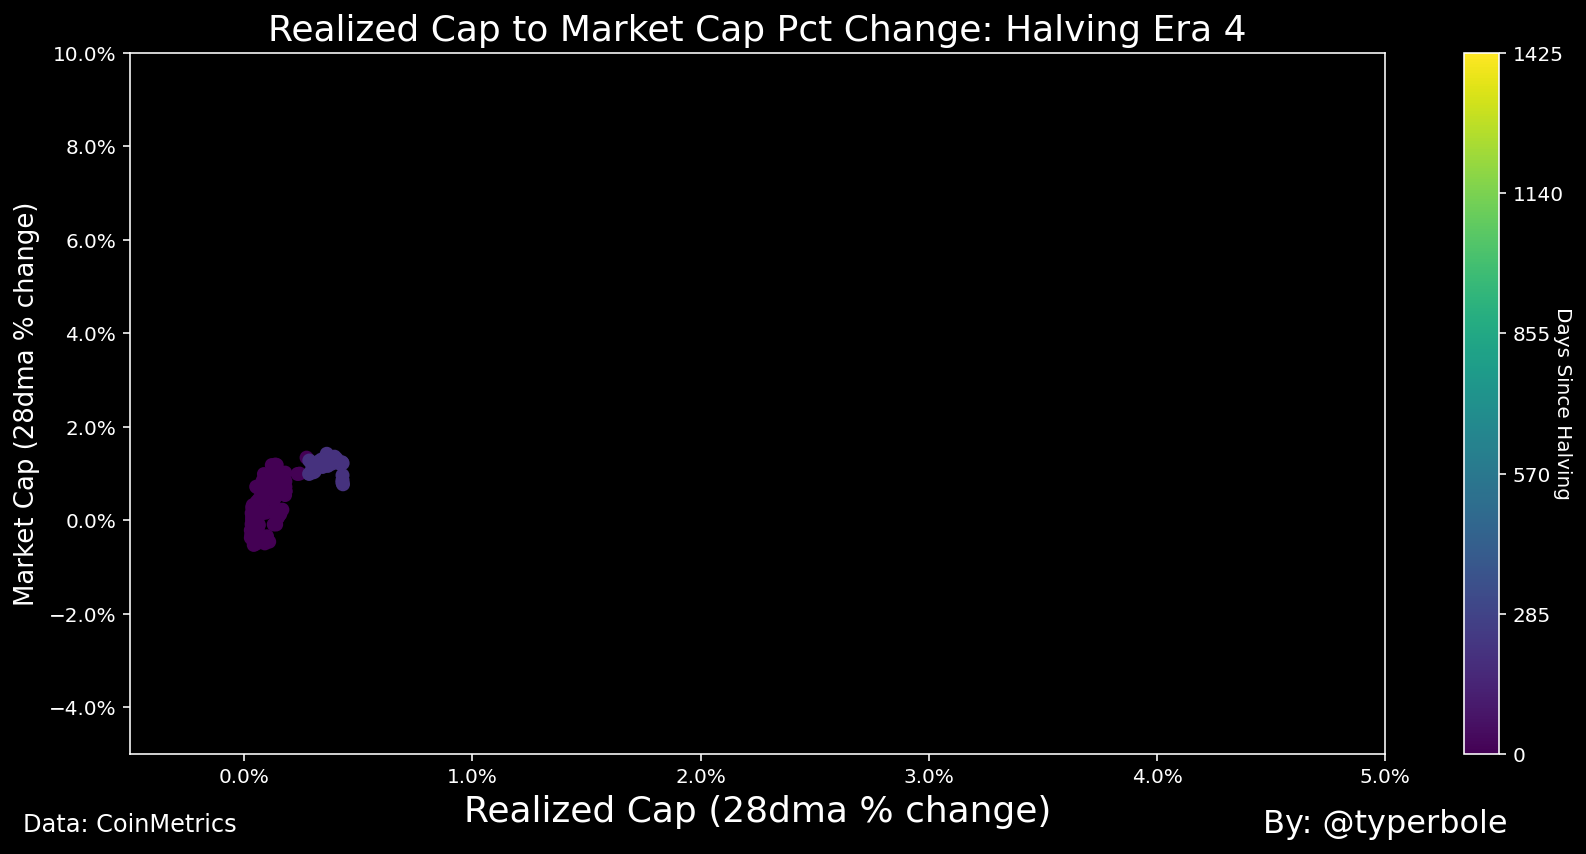

In [13]:
for halving_era in data.halving_era.unique():

    data_filter = data.loc[
        (data['halving_era'] == halving_era) 
    ]
    fig = plt.figure(
            figsize=[12, 6],
            clear=True,
            tight_layout=True
    )

    ax = plt.scatter(
        data_filter['CapRealUSDRoll28lnPctChange'] * 100, data_filter['CapMrktCurUSDRoll28lnPctChange'] * 100,
        c=[viridis(x) for x in (data_filter['days_since_halving'] / data.days_since_halving.max())]
    ).axes

    # ax.set_yscale("log")
    ax.set_ylim(-5, 10)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylabel('Market Cap (28dma % change)', fontsize=13)

    # ax.set_xscale("log")
    ax.set_xlim(-0.5, 5)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_xlabel('Realized Cap (28dma % change)', fontsize=18)

    ax.set_title('Realized Cap to Market Cap Pct Change: Halving Era {}'.format(halving_era_map.get(halving_era)), fontsize=18)

    ax.text(
        1, -0.1,
        "By: @typerbole",
        transform=ax.transAxes,
        horizontalalignment='center',
        verticalalignment='center', fontsize=16
    )

    ax.text(
        0, -0.1,
        "Data: CoinMetrics",
        transform=ax.transAxes,
        horizontalalignment='center',
        verticalalignment='center', fontsize=12
    )

    cbar = plt.colorbar()
    # cbar.ax.set_yticklabels(data_filter['days_since_halving'])
    cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])
    cbar.ax.set_ylabel('Days Since Halving', rotation=270)
    plt.show()

<ipython-input-21-74dd66f18b00>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])


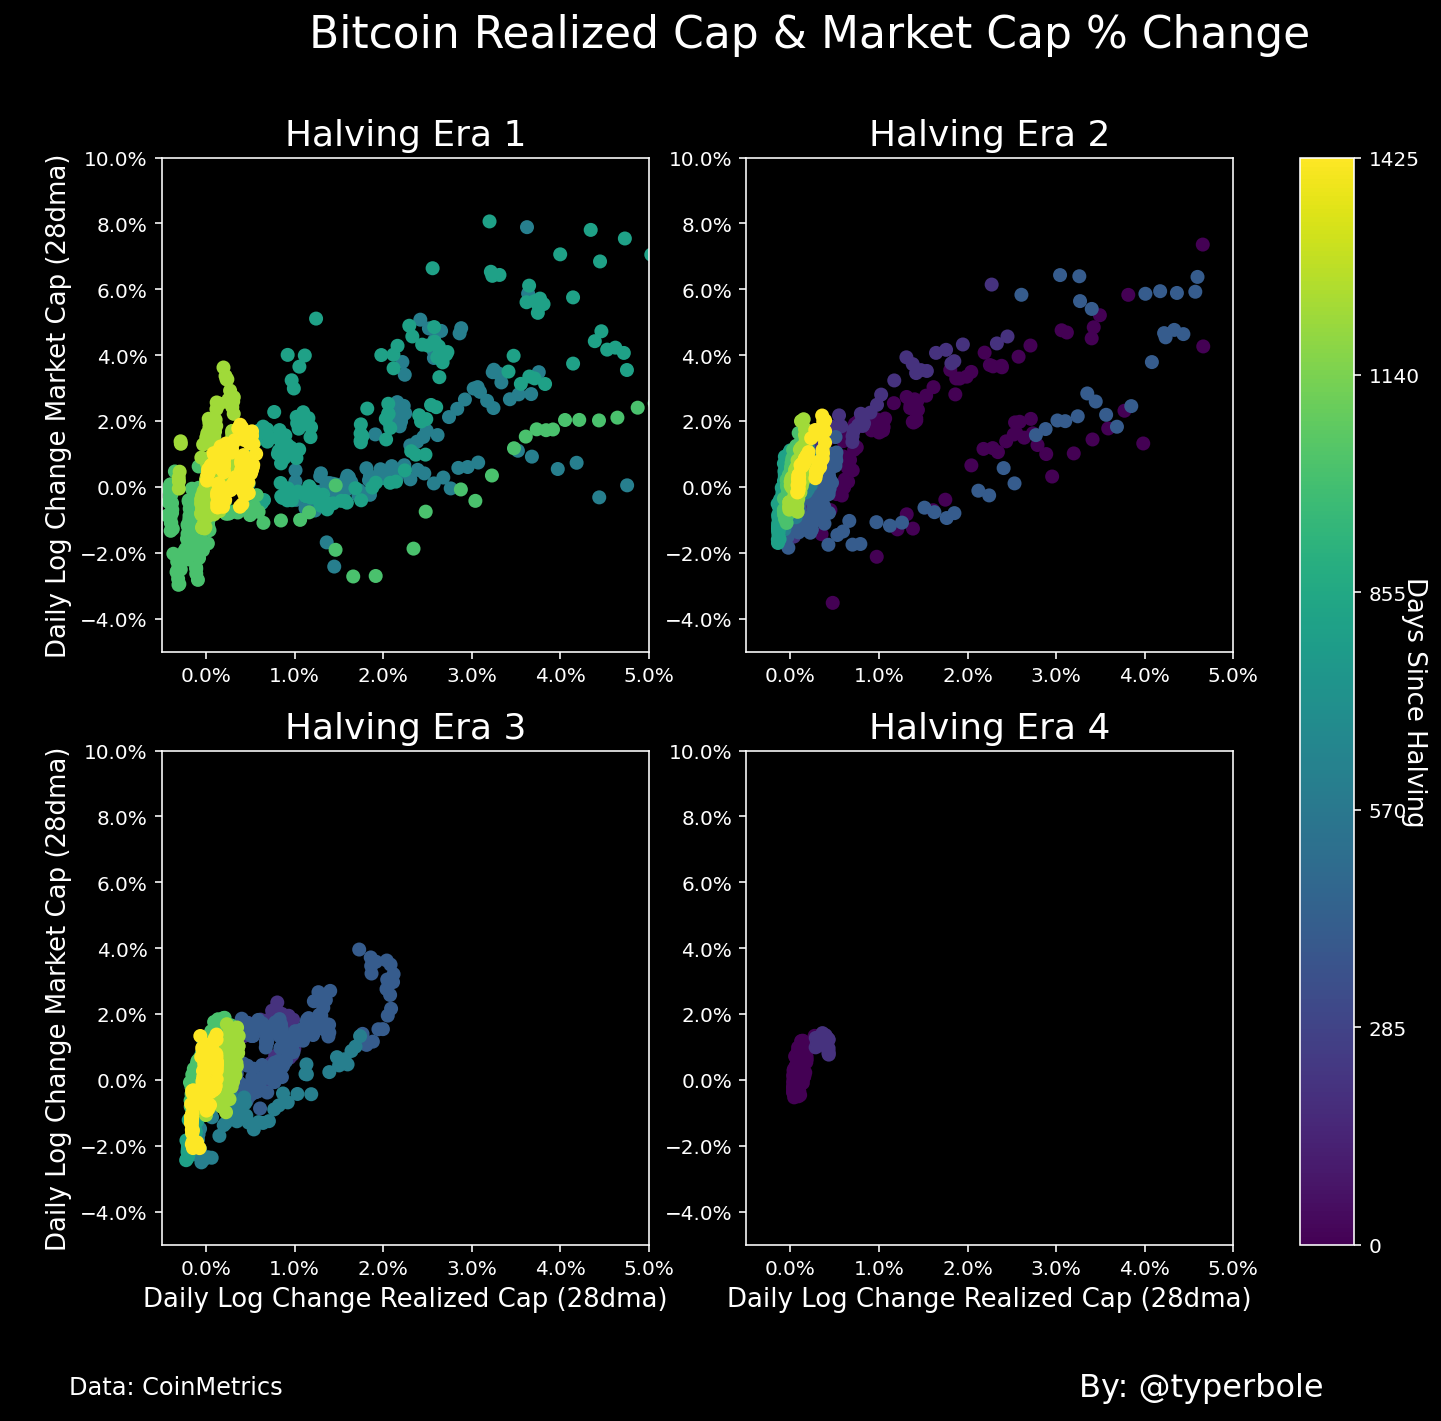

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
axs = [ax1, ax2, ax3, ax4]

for index, halving_era in enumerate(data.halving_era.unique()):
    data_filter = data.loc[
        (data['halving_era'] == halving_era) 
    ]

    im = axs[index].scatter(
        data_filter['CapRealUSDRoll28lnPctChange'] * 100, data_filter['CapMrktCurUSDRoll28lnPctChange'] * 100,
        c=[viridis(x) for x in (data_filter['days_since_halving'] / data.days_since_halving.max())]
    )

    # ax.set_yscale("log")
    axs[index].set_ylim(-5, 10)
    axs[index].yaxis.set_major_formatter(mtick.PercentFormatter())
    if index in [0, 2]:
        axs[index].set_ylabel('Daily Log Change Market Cap (28dma)', fontsize=13)

#     # ax.set_xscale("log")
    axs[index].set_xlim(-0.5, 5)
    axs[index].xaxis.set_major_formatter(mtick.PercentFormatter())
    if index in [2, 3]:
        axs[index].set_xlabel('Daily Log Change Realized Cap (28dma)', fontsize=13)

    axs[index].set_title('Halving Era {}'.format(halving_era_map.get(halving_era)), fontsize=18)

plt.text(
    2, -0.05,
    "By: @typerbole",
    transform=ax.transAxes,
    horizontalalignment='right',
    verticalalignment='center', fontsize=16
)

plt.text(
    0, -0.05,
    "Data: CoinMetrics",
    transform=ax.transAxes,
    horizontalalignment='left',
    verticalalignment='center', fontsize=12
)

cbar = fig.colorbar(im, ax=axs)

# # cbar.ax.set_yticklabels(data_filter['days_since_halving'])
cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])
cbar.ax.set_ylabel('Days Since Halving', rotation=270, fontsize=13)
    
fig.suptitle('Bitcoin Realized Cap & Market Cap % Change', fontsize=22)
plt.show()

<ipython-input-22-1c2325049b6c>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])


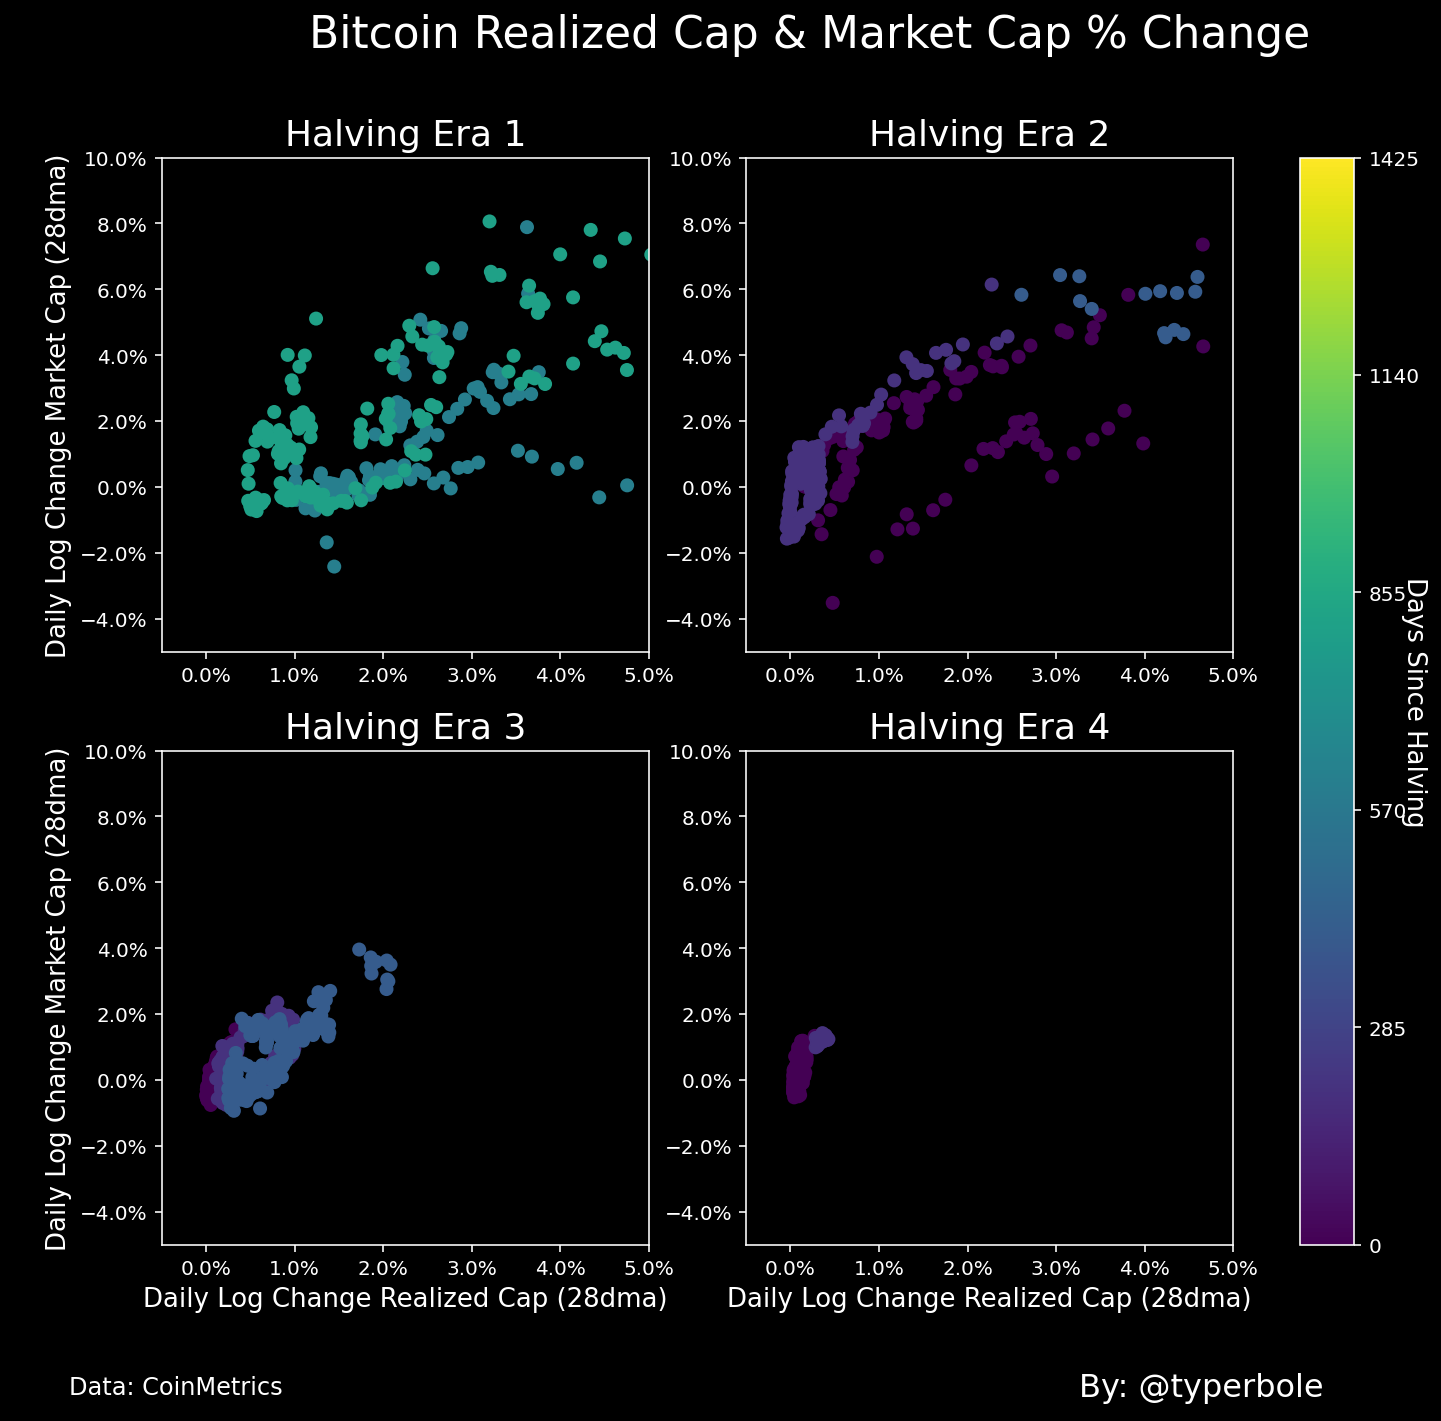

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
axs = [ax1, ax2, ax3, ax4]

for index, halving_era in enumerate(data.halving_era.unique()):
    max_price = data.loc[
            (data['halving_era'] == halving_era)
        ].PriceUSD.max()
    data_filter = data.loc[
        (data['halving_era'] == halving_era)
        & (data['days_since_halving'] <= data.loc[
            (data['halving_era'] == halving_era)
            & (data['PriceUSD'] == max_price)
        ].days_since_halving.max())
    ]

    im = axs[index].scatter(
        data_filter['CapRealUSDRoll28lnPctChange'] * 100, data_filter['CapMrktCurUSDRoll28lnPctChange'] * 100,
        c=[viridis(x) for x in (data_filter['days_since_halving'] / data.days_since_halving.max())]
    )

    # ax.set_yscale("log")
    axs[index].set_ylim(-5, 10)
    axs[index].yaxis.set_major_formatter(mtick.PercentFormatter())
    if index in [0, 2]:
        axs[index].set_ylabel('Daily Log Change Market Cap (28dma)', fontsize=13)

#     # ax.set_xscale("log")
    axs[index].set_xlim(-0.5, 5)
    axs[index].xaxis.set_major_formatter(mtick.PercentFormatter())
    if index in [2, 3]:
        axs[index].set_xlabel('Daily Log Change Realized Cap (28dma)', fontsize=13)

    axs[index].set_title('Halving Era {}'.format(halving_era_map.get(halving_era)), fontsize=18)

plt.text(
    2, -0.05,
    "By: @typerbole",
    transform=ax.transAxes,
    horizontalalignment='right',
    verticalalignment='center', fontsize=16
)

plt.text(
    0, -0.05,
    "Data: CoinMetrics",
    transform=ax.transAxes,
    horizontalalignment='left',
    verticalalignment='center', fontsize=12
)

cbar = fig.colorbar(im, ax=axs)

# # cbar.ax.set_yticklabels(data_filter['days_since_halving'])
cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])
cbar.ax.set_ylabel('Days Since Halving', rotation=270, fontsize=13)
    
fig.suptitle('Bitcoin Realized Cap & Market Cap % Change', fontsize=22)
plt.show()

<ipython-input-23-ad8795df0fd0>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])


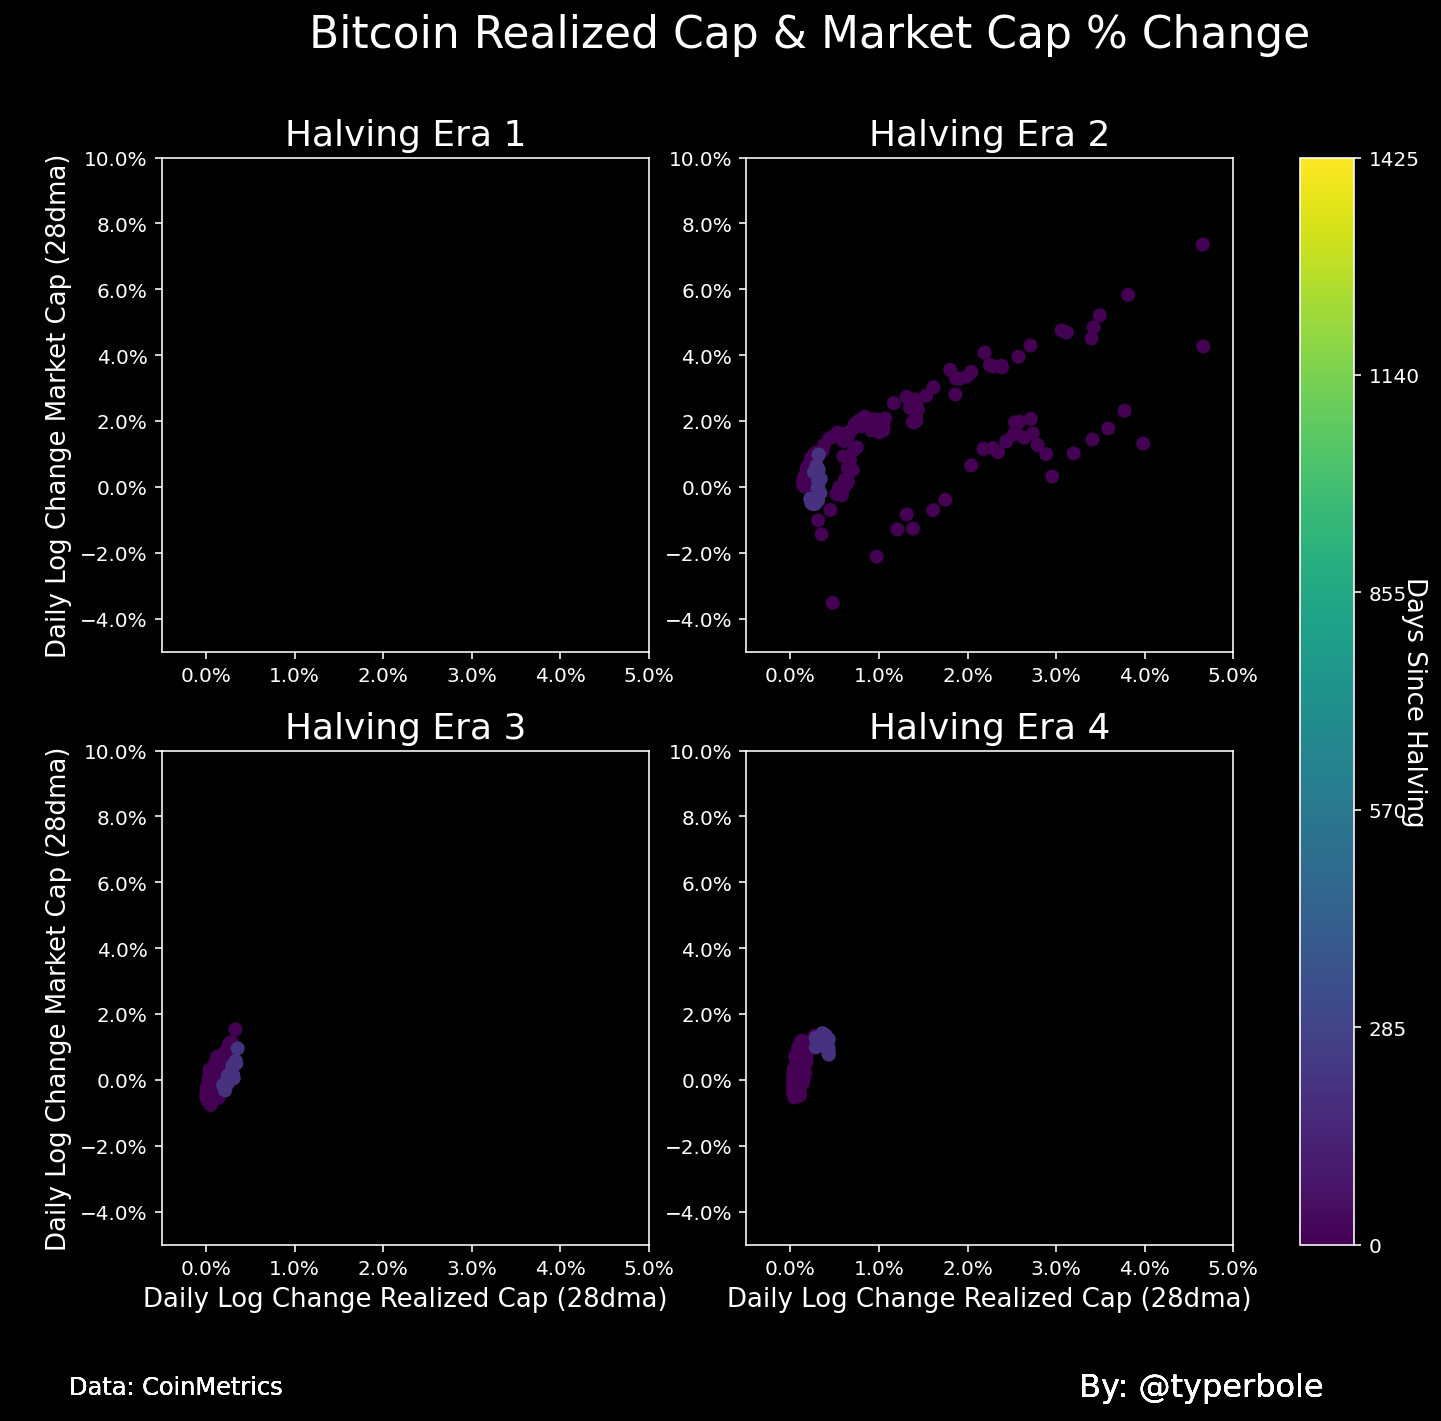

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
axs = [ax1, ax2, ax3, ax4]

for index, halving_era in enumerate(data.halving_era.unique()):
    data_filter = data.loc[
        (data['halving_era'] == halving_era)
        & (data['days_since_halving'] <= data.loc[data['halving_era'] == datetime.date(2020, 5, 11)].days_since_halving.max())
    ]

    im = axs[index].scatter(
        data_filter['CapRealUSDRoll28lnPctChange'] * 100, data_filter['CapMrktCurUSDRoll28lnPctChange'] * 100,
        c=[viridis(x) for x in (data_filter['days_since_halving'] / data.days_since_halving.max())]
    )

    # ax.set_yscale("log")
    axs[index].set_ylim(-5, 10)
    axs[index].yaxis.set_major_formatter(mtick.PercentFormatter())
    if index in [0, 2]:
        axs[index].set_ylabel('Daily Log Change Market Cap (28dma)', fontsize=13)

#     # ax.set_xscale("log")
    axs[index].set_xlim(-0.5, 5)
    axs[index].xaxis.set_major_formatter(mtick.PercentFormatter())
    if index in [2, 3]:
        axs[index].set_xlabel('Daily Log Change Realized Cap (28dma)', fontsize=13)

    axs[index].set_title('Halving Era {}'.format(halving_era_map.get(halving_era)), fontsize=18)

    plt.text(
        2, -0.05,
        "By: @typerbole",
        transform=ax.transAxes,
        horizontalalignment='right',
        verticalalignment='center', fontsize=16
    )

    plt.text(
        0, -0.05,
        "Data: CoinMetrics",
        transform=ax.transAxes,
        horizontalalignment='left',
        verticalalignment='center', fontsize=12
    )

cbar = fig.colorbar(im, ax=axs)

# # cbar.ax.set_yticklabels(data_filter['days_since_halving'])
cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])
cbar.ax.set_ylabel('Days Since Halving', rotation=270, fontsize=13)
    
fig.suptitle('Bitcoin Realized Cap & Market Cap % Change', fontsize=22)
plt.show()

In [17]:
import statsmodels.api as sm

In [18]:
# Create our data series
X = data_filter['CapRealUSDlnPctChange'] * 100
X = sm.add_constant(X)
y = data_filter['CapMrktCurUSDlnPctChange'] * 100

# Fit our model
model = sm.OLS(y, X).fit()

# Let's make predictions for the model over a range of transaction volume values so we can plot the line
line_x = np.log(np.arange(-5, 20, 1))
line_x = sm.add_constant(line_x)
line_y = model.get_prediction(line_x, transform=False)

# We'll also get the prediction & confidence intervals
prediction_interval = line_y.summary_frame(alpha=0.05)
line_y_mean = np.exp(prediction_interval['mean'])
line_y_lower_ci = np.exp(prediction_interval['obs_ci_lower'])
line_y_upper_ci = np.exp(prediction_interval['obs_ci_upper'])
line_y_lower_pi = np.exp(prediction_interval['mean_ci_lower'])
line_y_upper_pi = np.exp(prediction_interval['mean_ci_upper'])

# Print out the statistics
model.summary()

<ipython-input-18-02bd1ac31b27>:10: RuntimeWarning: divide by zero encountered in log
  line_x = np.log(np.arange(-5, 20, 1))
<ipython-input-18-02bd1ac31b27>:10: RuntimeWarning: invalid value encountered in log
  line_x = np.log(np.arange(-5, 20, 1))
/home/twood/anaconda3/lib/python3.8/site-packages/statsmodels/regression/_prediction.py:87: RuntimeWarning: invalid value encountered in add
  upper = self.predicted_mean + q * se


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     CapMrktCurUSDlnPctChange   R-squared:                       0.185
Model:                                  OLS   Adj. R-squared:                  0.181
Method:                       Least Squares   F-statistic:                     45.61
Date:                      Mon, 30 Nov 2020   Prob (F-statistic):           1.52e-10
Time:                              07:32:43   Log-Likelihood:                -466.46
No. Observations:                       203   AIC:                             936.9
Df Residuals:                           201   BIC:                             943.5
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.4105      0.205     -2.000      0.047      -0.815      -0.006
CapRealUSDlnPctChange     5.7532      0.852      6.754      0.000       4.073       7.433
==============================================================================
Omnibus:                       28.633   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.151
Skew:                          -0.589   Prob(JB):                     7.91e-17
Kurtosis:                       5.716   Cond. No.                         5.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'CapRealUSDlnPctChange', fig=fig)

In [ ]:
halving_era = pd.to_datetime('2016-07-10')#pd.to_datetime('2020, 5, 11')

data_filter = weekly.loc[
    (weekly['halving_era'] == halving_era) 
#     &
#     ((data['CapRealUSDRoll7lnPctChange'] > 0) == (data['CapMrktCurUSDFFRoll7lnPctChange'] > 0))
]
fig = plt.figure(
        figsize=[12, 6],
        clear=True,
        tight_layout=True
)

ax = plt.scatter(
    data_filter['CapRealUSDlnPctChange'] * 100, data_filter['CapMrktCurUSDlnPctChange'] * 100,
#     c=(data_filter['days_since_halving'] / data.days_since_halving.max())
    c=[viridis(x) for x in (data_filter['days_since_halving'] / data.days_since_halving.max())]
).axes

# ax.set_yscale("log")
# ax.set_ylim(-40, 40)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Weekly Log Change Market Cap', fontsize=13)

# ax.set_xscale("log")
# ax.set_xlim(-10, 10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Weekly Log Change Realized Cap', fontsize=18)

ax.set_title('Realized Cap to Market Cap', fontsize=18)

ax.plot(
    np.arange(1000000000, 1000000000000, 1000000000), line_y_mean, linestyle='dashed', color='lightblue',
    label='Model Prediction')

ax.text(
    1, -0.1,
    "By: @typerbole",
    transform=ax.transAxes,
    horizontalalignment='center',
    verticalalignment='center', fontsize=16
)

ax.text(
    0, -0.1,
    "Data: CoinMetrics",
    transform=ax.transAxes,
    horizontalalignment='center',
    verticalalignment='center', fontsize=12
)

cbar = plt.colorbar()
# cbar.ax.set_yticklabels(data_filter['days_since_halving'])
cbar.ax.set_yticklabels([int(x) for x in cbar.get_ticks() * data.days_since_halving.max()])
plt.show()

In [ ]:
fig = plt.figure(
        figsize=[12, 6],
        clear=True,
        tight_layout=True
)

ax = plt.scatter(
    block_space_daily_recent['TxTfrValUSD'], block_space_daily_recent['fees_usd_per_vbyte'],
    c=block_space_daily_recent['datetime'], 
#     cmap='hot'
).axes

ax.set_yscale("log")
ax.set_ylim(0.0001, 10)
ax.set_yticklabels(['${:.3f}'.format(x) for x in ax.get_yticks()])
ax.set_ylabel('Daily Mean Fee Rate (Total $USD Fees / Total Block vByte)', fontsize=13)

ax.set_xscale("log")
ax.set_xlim(1000000000, 1000000000000)
ax.set_xticklabels(['${:.0f}B'.format(x / 1000000000) for x in ax.get_xticks()])
ax.set_xlabel('Daily $USD Transaction Volume', fontsize=22)

ax.set_title('Daily Bitcoin $USD Transaction Volume vs. Daily Fee Rate', fontsize=18)
ax.text(
        0.97, 0.02,
        "By: @typerbole",
        transform=ax.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom', fontsize=16
)
ax.text(0.5, 0.9, 
        "ln($USD/vByte) = 1.44 * ln($USD Transaction Vol) - 38.08",
         transform = ax.transAxes,
         horizontalalignment='center',
         verticalalignment='center', fontsize=16
        )
ax.text(0.5, 0.85, 
        "R-sq = 0.482",
         transform = ax.transAxes,
         horizontalalignment='center',
         verticalalignment='center', fontsize=16
       )

ax.plot(
    np.arange(1000000000, 1000000000000, 1000000000), line_y_mean, linestyle='dashed', color='lightblue',
    label='Model Prediction')

ax.text(
    1, -0.1,
    "By: @typerbole",
    transform=ax.transAxes,
    horizontalalignment='center',
    verticalalignment='center', fontsize=16
)

ax.text(
    0, -0.1,
    "Data: Bitcoin ETL & CoinMetrics",
    transform=ax.transAxes,
    horizontalalignment='center',
    verticalalignment='center', fontsize=12
)

cbar = plt.colorbar()
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))
plt.savefig('img/04_block_space_regression.png'.format(type))
plt.show()